In [27]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all = pd.read_csv('../expedia_data/all_data.csv')

print('Dataset has %d record'%len(all))
print('Dataset has %d search_id (accounts)'%len(all['srch_id'].unique().tolist()))

Dataset has 908750 record
Dataset has 36518 search_id (accounts)


there are 3 weeks in total.


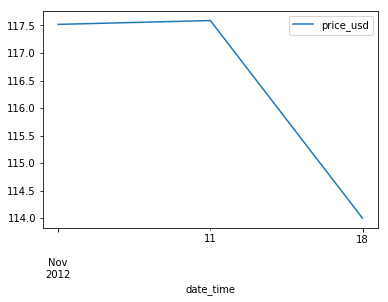

In [46]:
# TODO: split dataset by weeks

all['date_time'] = pd.to_datetime(all.date_time)
all_ = all.set_index('date_time')

srch_ids = all['srch_id'].unique().tolist()

srch_id_df_list = []      # get subset df for each srch_id, and append it to a list
for srch_id in srch_ids:
    df = all_[all_['srch_id'] == srch_id]
    srch_id_df_list.append(df)

weekly = all_.resample('W').median()
print('there are %d weeks in total.'%len(weekly))
weekly.head()

weekly[['price_usd']].plot()

In [44]:
# checking
print(srch_id_df_list[0].index.unique().tolist())
print(srch_id_df_list[1].index.unique().tolist())
print(srch_id_df_list[2].index.unique().tolist())

[Timestamp('2012-11-01 00:01:37')]
[Timestamp('2012-11-01 00:03:24')]
[Timestamp('2012-11-01 00:05:23')]


In [3]:
# # get sampled data
# def get_sampled_data(size, data):
#     '''
#     This function takes in the whole dataset, 
#     and outout a sampled subset with data size specified
#     '''
#     interval_range = len(data)//size
#     mid_idx_lst = []
#     for i in range(1,size+1):
#         mid_idx = (interval_range*(i-1) + interval_range*i)//2
#         mid_idx_lst.append(mid_idx)

#     data_sampled = data.iloc[mid_idx_lst]
#     return data_sampled
    
# sampled = get_sampled_data(5000, all)

In [4]:
# handle NA values
sampled = sampled.fillna(sampled.median())
sampled.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,new_comp5_rate_percent_diff,new_comp6_rate,new_comp6_inv,new_comp6_rate_percent_diff,new_comp7_rate,new_comp7_inv,new_comp7_rate_percent_diff,new_comp8_rate,new_comp8_inv,new_comp8_rate_percent_diff
90,7086,2012-11-01 00:06:20,24,216,4.500,745.42,220,131958,4,4.0,...,0,0,0,0,0,0,0,0,0,0
271,307902,2012-11-01 00:12:06,24,216,3.275,138.34,164,138356,4,4.5,...,0,0,0,0,0,0,0,0,0,0
452,349474,2012-11-01 00:22:43,24,216,3.280,107.96,215,50818,4,4.0,...,0,0,0,0,1,1,0,0,0,0
633,26168,2012-11-01 00:35:47,32,220,3.275,138.34,219,91206,2,3.5,...,0,0,0,0,0,0,0,1,1,0
814,435038,2012-11-01 00:47:56,24,216,3.275,138.34,196,99532,4,3.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print('sampled dataset has %d unique '%sampled['srch_id'].nunique())

sampled dataset has 5000 unique property


In [12]:
properties = sampled['prop_id'].unique().tolist()

# TODO: get subset df for each property
property_df_list = []
for property in properties:
    df = sampled[sampled['prop_id'] == property]
    property_df_list.append(df)
    
len(property_df_list)

4488

In [ ]:
def split_data(data):
    '''
    This function takes in the whole data set and divide it into training, validation and test data;
    split into 0.8 and 0.2 first; second split using the same ratio into training and valiation
    '''
    training_size_large = int(len(data) * 0.8)   
    validation_size = int(training_size_large * 0.2)
    training_size = training_size_large - validation_size
    test_size = int(len(data) * 0.2)
    
    print('training size: %d'%training_size)
    print('validation size: %d'%validation_size)
    print('test size: %d'%test_size)
    
    # split data manually
    training_data = data[0: training_size]
    validation_data = data[training_size:(training_size + validation_size)]
    test_data = data[(training_size + validation_size): (training_size + validation_size + test_size)]
    
    return training_data, validation_data, test_data
    
training, validation, test = split_data(sampled)


# X_train = training[variables].values
# y_train = training['price_usd'].values

# X_val = validation[variables].values
# y_val = validation['price_usd'].values

# X_test = test[variables].values
# y_test = test['price_usd'].values


### remain 'date_time' in training model
variables = [col for col in all.columns.unique().tolist() if col not in ['price_usd','date_time']]
# variables = [col for col in all.columns.unique().tolist() if col not in ['price_usd']]

### keep variable names in df
X_train = training[variables]
y_train = training['price_usd']

X_val = validation[variables]
y_val = validation['price_usd']

X_test = test[variables]
y_test = test['price_usd']

In [1]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model